In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/gdrive')
%cd / gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/ gdrive'
/content


In [56]:
trainfile = r'/gdrive/My Drive/Assignments/Assignment2/FraudDetection/TRAIN.csv'
testfile = r'/gdrive/My Drive/Assignments/Assignment2/FraudDetection/TEST.csv'

trainData = pd.read_csv(trainfile)
testData = pd.read_csv(testfile)

#hot encoding
trainData_copy = trainData.iloc[:, :-1]
testData_copy = testData.iloc[:, :-1]

categoricalFeatures = ["MONTH","DAYOFWEEK", "MAKE", "ACCIDENTAREA", "DAYOFWEEKCLAIMED", "MONTHCLAIMED", "SEX", "MARITALSTATUS", "FAULT", "POLICYTYPE", "VEHICLECATEGORY","DRIVERRATING", "VEHICLEPRICE", "DAYS_POLICY_ACCIDENT", "DAYS_POLICY_CLAIM", "PASTNUMBEROFCLAIMS", "AGEOFVEHICLE", "AGEOFPOLICYHOLDER", "POLICEREPORTFILED", "WITNESSPRESENT", "AGENTTYPE", "NUMBEROFSUPPLIMENTS", "ADDRESSCHANGE_CLAIM", "NUMBEROFCARS", "BASEPOLICY"]

combined_Data = pd.concat([trainData_copy, testData_copy], keys= [0,1])
combined_Data = pd.get_dummies(combined_Data,columns = categoricalFeatures )
#print(combined_Data.head())
#print(testData.head())
X_train = combined_Data.xs(0) 
X_test = combined_Data.xs(1)

Y_train = trainData["FRAUDFOUND"]
Y_test = testData["FRAUDFOUND"]

X_train.to_csv("/gdrive/My Drive/Assignments/Assignment2/FraudDetection/practice.csv")
print(X_train.head())
print(Y_train.head())
print(X_test.head())
print(Y_test.head())

   WEEKOFMONTH  WEEKOFMONTHCLAIMED  ...  BASEPOLICY_Collision  BASEPOLICY_Liability
0            3                   4  ...                     1                     0
1            5                   1  ...                     0                     0
2            1                   1  ...                     0                     0
3            1                   3  ...                     0                     0
4            5                   1  ...                     1                     0

[5 rows x 147 columns]
0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: FRAUDFOUND, dtype: object
   WEEKOFMONTH  WEEKOFMONTHCLAIMED  ...  BASEPOLICY_Collision  BASEPOLICY_Liability
0            3                   4  ...                     1                     0
1            5                   1  ...                     0                     0
2            1                   1  ...                     0                     0
3            1                   3  ...                    

In [57]:
#normal prediction using Decision Tree Classifier 
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
clf_predict = clf.predict(X_test)
print("---Normal Decision Tree Classifier: ")
print("Classification Report")
print(confusion_matrix(Y_test, clf_predict))
print(classification_report(Y_test, clf_predict))


---Normal Decision Tree Classifier: 
Classification Report
[[10960  1460]
 [   54   444]]
              precision    recall  f1-score   support

          No       1.00      0.88      0.94     12420
         Yes       0.23      0.89      0.37       498

    accuracy                           0.88     12918
   macro avg       0.61      0.89      0.65     12918
weighted avg       0.97      0.88      0.91     12918



0.8870069650583009


<Figure size 432x288 with 0 Axes>

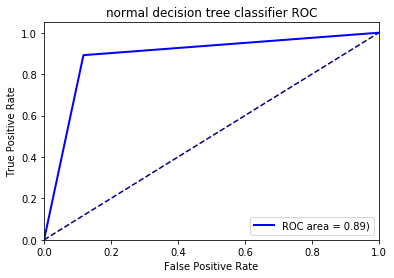

In [58]:
#AUC for evaluation  of normal decision tree classifier
Y_score_array = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('normal decision tree classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [59]:
#Hyperparameter Tuning
#Using random search for Decision tree classifier

parameters = {'min_samples_leaf': range(10,100,10), 'max_depth': range(5, 80,10), 'criterion': ['gini', 'entropy']}
clf_random = RandomizedSearchCV(clf, parameters, n_iter =15 , cv = 5)
clf_random.fit(X_train, Y_train)
random_param = clf_random.best_params_
print(random_param)

#using best parameters obtained, we create decision tree classifier
clfr = DecisionTreeClassifier(**random_param)
clfr.fit(X_train, Y_train)
clfr_predict = clfr.predict(X_test)

print("Classification report for Decision tree aftee hypertuning using random search")
print(classification_report(Y_test, clfr_predict))


{'min_samples_leaf': 30, 'max_depth': 5, 'criterion': 'entropy'}
Classification report for Decision tree aftee hypertuning using random search
              precision    recall  f1-score   support

          No       0.97      0.90      0.93     12420
         Yes       0.12      0.35      0.18       498

    accuracy                           0.88     12918
   macro avg       0.55      0.62      0.56     12918
weighted avg       0.94      0.88      0.90     12918



<class 'numpy.ndarray'>
0.8026594299904934


<Figure size 432x288 with 0 Axes>

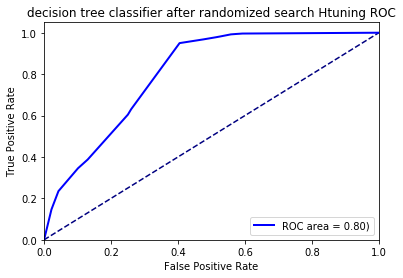

In [60]:
#AUC for evaluation  of decision tree classifier after randomized search Htuning
Y_score_array = clfr.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
print(type(fpr))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('decision tree classifier after randomized search Htuning ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [61]:
#Using grid search for Decision tree classifier

clf_grid = GridSearchCV(clf, parameters, cv = 5)
clf_grid.fit(X_train, Y_train)
grid_param = clf_grid.best_params_
print(grid_param)

#using best parameters obtained, we create decision tree classifier
clfg = DecisionTreeClassifier(**grid_param)
clfg.fit(X_train, Y_train)
clfg_predict = clfg.predict(X_test)

print("Classification report for Decision tree aftee hypertuning using random search")
print(classification_report(Y_test, clfg_predict))

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30}
Classification report for Decision tree aftee hypertuning using random search
              precision    recall  f1-score   support

          No       0.97      0.90      0.93     12420
         Yes       0.12      0.35      0.18       498

    accuracy                           0.88     12918
   macro avg       0.55      0.62      0.56     12918
weighted avg       0.94      0.88      0.90     12918



<class 'numpy.ndarray'>
0.8027409153522302


<Figure size 432x288 with 0 Axes>

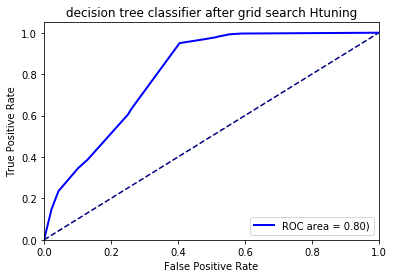

In [67]:
#AUC for evaluation  of decision tree classifier after grid search Htuning
Y_score_array = clfg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
print(type(fpr))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('decision tree classifier after grid search Htuning')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [100]:
#predicting using normal random forest trees 
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
rfc_predict = rfc.predict(X_test)
print("Classification report for prediction using normal random forest trees:")
print(classification_report(Y_test, rfc_predict))


Classification report for prediction using normal random forest trees:
              precision    recall  f1-score   support

          No       0.99      0.96      0.98     12420
         Yes       0.45      0.78      0.57       498

    accuracy                           0.96     12918
   macro avg       0.72      0.87      0.77     12918
weighted avg       0.97      0.96      0.96     12918



0.9415200253510014


<Figure size 432x288 with 0 Axes>

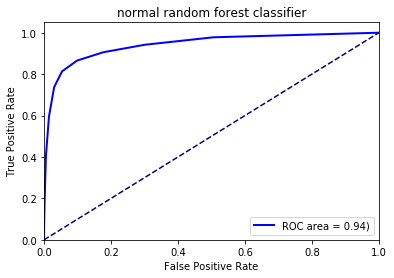

In [68]:
#AUC for evaluation  of normal random forest classifier

Y_score_array = rfc.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('normal random forest classifier')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [88]:
#Hyperparameter tuning in Random Forest trees
#using randomized search

parametersRf = {'min_samples_leaf': range(10,100,10), 'max_depth': range(10, 80,5), 'criterion': ['gini', 'entropy']}
rfc_random = RandomizedSearchCV(rfc, parametersRf, n_iter = 15, cv = 5)
rfc_random.fit(X_test, Y_test)
rfc_random_best_params = rfc_random.best_params_
print(rfc_random_best_params)

#using the best parameters obtained during randomized search for rfc
rfcr = RandomForestClassifier(**rfc_random_best_params)
rfcr.fit(X_train, Y_train)
rfcr_predict= rfcr.predict(X_test)
print("Classification report for random forest tree after hypertuning using random search")
print(confusion_matrix(Y_test, rfcr_predict))
print(classification_report(Y_test, rfcr_predict))


{'min_samples_leaf': 70, 'max_depth': 15, 'criterion': 'gini'}
Classification report for random forest tree after hypertuning using random search
[[12420     0]
 [  498     0]]
              precision    recall  f1-score   support

          No       0.96      1.00      0.98     12420
         Yes       0.00      0.00      0.00       498

    accuracy                           0.96     12918
   macro avg       0.48      0.50      0.49     12918
weighted avg       0.92      0.96      0.94     12918



0.7940206073892996


<Figure size 432x288 with 0 Axes>

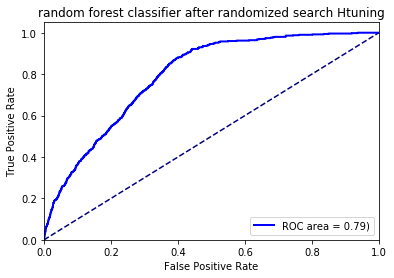

In [81]:
#AUC for evaluation  of random forest classifier after randomized search Htuning
Y_score_array = rfcr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('random forest classifier after randomized search Htuning')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [90]:
#Hyperparameter tuning in Random Forest trees
#using grid search

rfc_grid = GridSearchCV(rfc, parametersRf, cv = 5)
rfc_grid.fit(X_test, Y_test)
rfc_grid_best_params = rfc_grid.best_params_
print(rfc_grid_best_params)

#using the best parameters obtained during randomized search for rfc
rfcg = RandomForestClassifier(**rfc_grid_best_params)
rfcg.fit(X_train, Y_train)
rfcg_predict= rfcg.predict(X_test)
print("Classification report for random forest tree after hypertuning using grid search")
print(classification_report(Y_test, rfcg_predict))

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
Classification report for random forest tree after hypertuning using grid search
              precision    recall  f1-score   support

          No       0.96      0.99      0.98     12420
         Yes       0.32      0.06      0.10       498

    accuracy                           0.96     12918
   macro avg       0.64      0.53      0.54     12918
weighted avg       0.94      0.96      0.95     12918



0.8374023469077598


<Figure size 432x288 with 0 Axes>

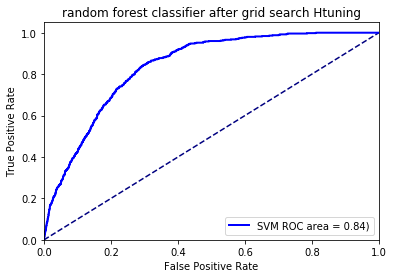

In [86]:
#AUC for evaluation  of random forest classifier after grid search Htuning
Y_score_array = rfcg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_score_array[:,1], pos_label = "Yes")
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('random forest classifier after grid search Htuning')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()